In [102]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
class EPADataProcessor:
    def __init__(self, config_path):
        with open(config_path, 'r') as f:
            self.config = yaml.safe_load(f)
        self.epa_file_path = self.config['paths']['epa_file_path']
        self.dataframes = []
        self.total_df = None

    def clean_dataframe(self, df, threshold_ratio=None):
        if threshold_ratio is None:
            threshold_ratio = self.config.get('threshold_ratio', 0.75)
        threshold = len(df) * threshold_ratio
        mask = df.apply(lambda col: ((col == 0) | (col.isna()) | (col == '')).sum() <= threshold, axis=0)
        df = df.loc[:, mask]

        mask = df['50. UNIT OF MEASURE'] == 'Grams'
        for col in self.config['target_columns'].keys():
            if col in df.columns:
                df.loc[mask, col] = df.loc[mask, col] / 1000

        df = df.drop(columns=self.config['columns_to_remove'])
        df = df.sort_values(by=self.config['columns_to_sort'])
        return df

    def process_year(self, year):
        df = pd.read_csv(f'{self.epa_file_path}/{year}_us.csv')
        df = self.clean_dataframe(df)
        grouped = df.groupby(self.config['columns_to_group_by']).sum()
        rename_map = {old_col: f'{year}_{new_col}' for old_col, new_col in self.config['target_columns'].items()}
        rename_map_filtered = {k: v for k, v in rename_map.items() if k in grouped.columns}
        grouped = grouped.rename(columns=rename_map_filtered)
        self.dataframes.append(grouped)

    def process_all_years(self):
        for year in self.config['years']:
            self.process_year(year)
        self.total_df = pd.concat(self.dataframes, axis=1).reset_index()

processor = EPADataProcessor('config.yaml')
processor.process_all_years()
total_df = processor.total_df

/var/folders/k1/f80nhqjd4qz4yjj0tc8hts2c0000gp/T/ipykernel_15590/2869800051.py:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{self.epa_file_path}/{year}_us.csv')
/var/folders/k1/f80nhqjd4qz4yjj0tc8hts2c0000gp/T/ipykernel_15590/2869800051.py:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{self.epa_file_path}/{year}_us.csv')
/var/folders/k1/f80nhqjd4qz4yjj0tc8hts2c0000gp/T/ipykernel_15590/2869800051.py:26: DtypeWarning: Columns (8,30,31,33,35,40,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{self.epa_file_path}/{year}_us.csv')
/var/folders/k1/f80nhqjd4qz4yjj0tc8hts2c0000gp/T/ipykernel_15590/2869800051.py:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{self.epa_file_path}/{year}_us.csv')
/var/folders/k

In [104]:
total_df

,4. FACILITY NAME,12. LATITUDE,13. LONGITUDE,22. INDUSTRY SECTOR CODE,2014_ON-SITE RELEASE TOTAL,2014_OFF-SITE RELEASE TOTAL,2014_TOTAL TRANSFER,2014_TOTAL RELEASES,2014_PRODUCTION WASTE,2015_ON-SITE RELEASE TOTAL,...,2022_ON-SITE RELEASE TOTAL,2022_OFF-SITE RELEASE TOTAL,2022_TOTAL TRANSFER,2022_TOTAL RELEASES,2022_PRODUCTION WASTE,2023_ON-SITE RELEASE TOTAL,2023_OFF-SITE RELEASE TOTAL,2023_TOTAL TRANSFER,2023_TOTAL RELEASES,2023_PRODUCTION WASTE
0,1000PALMS VISTA CHINO PLANT,33.845320,-116.375570,327.0,0.000,0.00,0.0,0.000,0.000,NaN,...,0.1000,0.00,0.0,0.1000,1.000000e-01,0.10000,0.0000,0.000000e+00,0.10000,1.000000e-01
1,11TH STREET BATCH PLANT,36.148000,-95.825780,327.0,0.000,0.00,0.0,0.000,0.000,0.000,...,0.0000,0.00,0.0,0.0000,0.000000e+00,0.00000,0.0000,0.000000e+00,0.00000,0.000000e+00
2,14096 - PROSPER,33.229268,-96.821519,327.0,0.000,0.00,0.0,0.000,0.000,0.121,...,0.0387,0.00,0.0,0.0387,3.870000e-02,0.06800,0.0000,0.000000e+00,0.06800,6.800000e-02
3,1500 SOUTH TIBBS LLC,39.740281,-86.218331,325.0,67410.000,42068.75,531260.0,109478.750,5590351.000,58013.000,...,48937.0000,27139.96,416614.0,76076.9600,5.353191e+07,16624.00000,19034.8700,2.006182e+06,35658.87000,2.388467e+07
4,193 DOCK,30.037596,-92.637763,4247.0,7.551,0.00,0.0,7.551,7.551,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30709,WESTERN REFINING ALBUQUERQUE FUEL TERMINAL,35.045800,-106.647220,4247.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5885.00000,0.0000,2.200000e+01,5885.00000,5.907000e+03
30710,WFS - GULF COAST CO MARKHAM CRYOGENIC PLANT,29.036661,-96.078510,211.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00000,0.0000,0.000000e+00,0.00000,0.000000e+00
30711,YANKEE CANDLE CO,42.443067,-72.617477,339.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.76000,0.0000,5.080000e+02,6.76000,8.527600e+02
30712,ZINKPOWER WACO,31.492900,-97.191000,332.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,267.20914,11660.4169,1.166042e+04,11927.62604,1.192763e+04


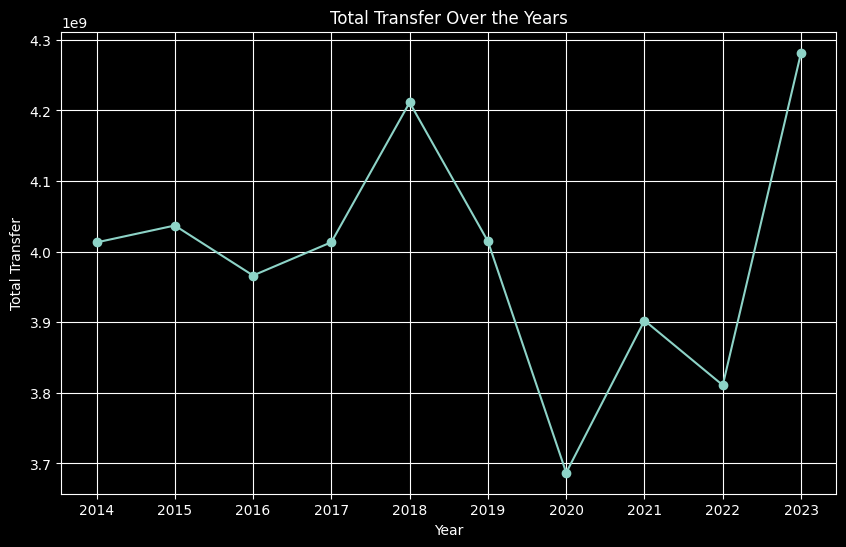

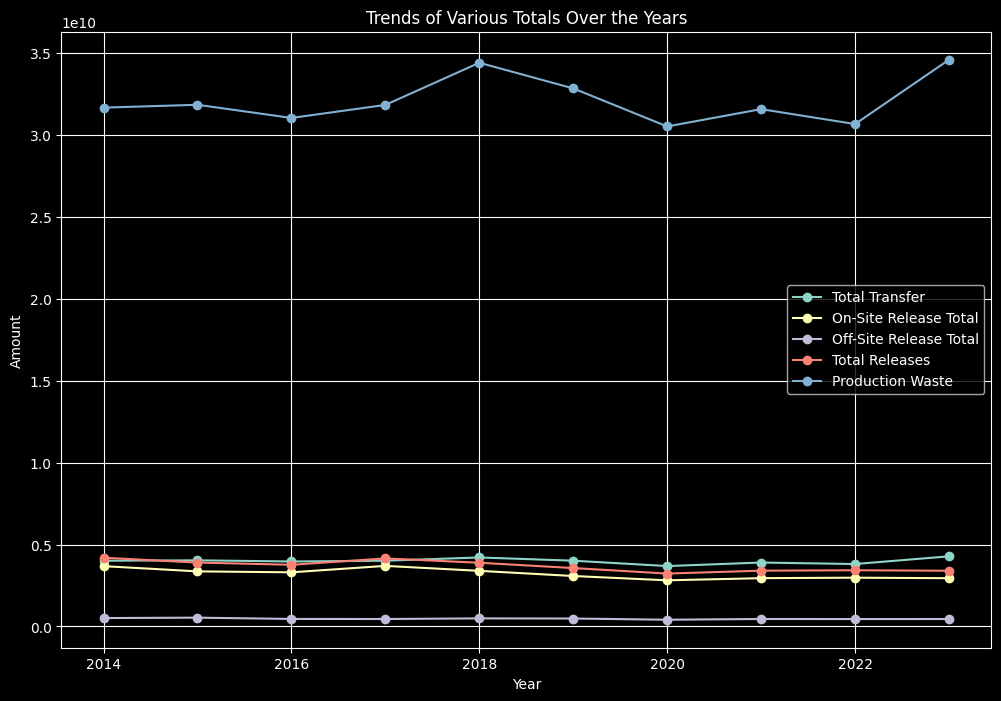

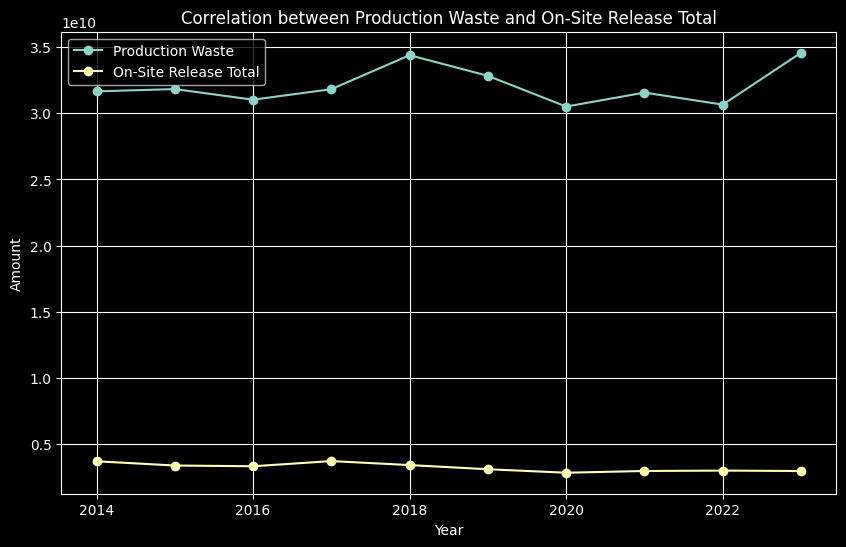

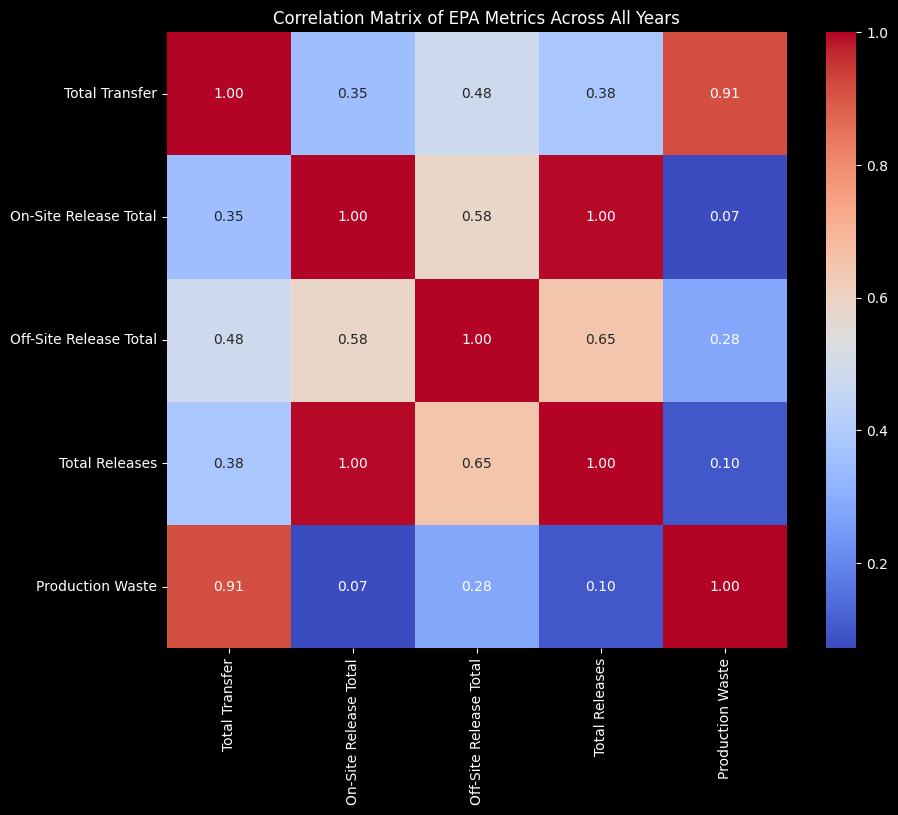

In [105]:
import seaborn as sns

class EPADataVisualizer:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.years = config['years']
        self.columns_to_plot = {
            'TOTAL TRANSFER': 'Total Transfer',
            'ON-SITE RELEASE TOTAL': 'On-Site Release Total',
            'OFF-SITE RELEASE TOTAL': 'Off-Site Release Total',
            'TOTAL RELEASES': 'Total Releases',
            'PRODUCTION WASTE': 'Production Waste'
        }
    
    def _get_column_names(self, column_type):
        """Generate column names for a specific metric across all years"""
        return [f'{year}_{column_type}' for year in self.years]
    
    def _calculate_yearly_sums(self, column_type):
        """Calculate sum of values for a specific metric across all years"""
        columns = self._get_column_names(column_type)
        return self.df[columns].sum()
    
    def plot_single_metric_trend(self, metric, figsize=(10, 6)):
        """Plot trend for a single metric over years"""
        sums = self._calculate_yearly_sums(metric)
        
        plt.figure(figsize=figsize)
        sums.plot(kind='line', marker='o', title=f'{metric.replace("_", " ").title()} Over the Years')
        plt.xlabel('Year')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.xticks(ticks=range(len(self.years)), labels=self.years)
        plt.grid(True)
        plt.show()
    
    def plot_multiple_metrics_trend(self, figsize=(12, 8)):
        """Plot trends for multiple metrics on the same chart"""
        plt.figure(figsize=figsize)
        
        for col, label in self.columns_to_plot.items():
            sums = self._calculate_yearly_sums(col)
            plt.plot(self.years, sums, marker='o', label=label)
        
        plt.xlabel('Year')
        plt.ylabel('Amount')
        plt.title('Trends of Various Totals Over the Years')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_correlation(self, metric1, metric2, figsize=(10, 6)):
        """Plot correlation between two metrics"""
        sums1 = self._calculate_yearly_sums(metric1)
        sums2 = self._calculate_yearly_sums(metric2)
        
        plt.figure(figsize=figsize)
        plt.plot(self.years, sums1, label=metric1.replace('_', ' ').title(), marker='o')
        plt.plot(self.years, sums2, label=metric2.replace('_', ' ').title(), marker='o')
        
        plt.xlabel('Year')
        plt.ylabel('Amount')
        plt.title(f'Correlation between {metric1.replace("_", " ").title()} and {metric2.replace("_", " ").title()}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_correlation_matrix(self, figsize=(10, 8)):
        """Plot correlation matrix heatmap for all metrics across all years"""
        # Create a dataframe with yearly sums for all metrics
        correlation_data = {}
        for col, label in self.columns_to_plot.items():
            yearly_sums = self._calculate_yearly_sums(col)
            correlation_data[label] = yearly_sums.values
        
        correlation_df = pd.DataFrame(correlation_data, index=self.years)
        correlation_matrix = correlation_df.corr()
        
        plt.figure(figsize=figsize)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of EPA Metrics Across All Years')
        plt.show()
    
    def generate_all_plots(self):
        """Generate all standard plots"""
        # Single metric trend
        self.plot_single_metric_trend('TOTAL TRANSFER')
        
        # Multiple metrics trend
        self.plot_multiple_metrics_trend()
        
        # Correlation plot
        self.plot_correlation('PRODUCTION WASTE', 'ON-SITE RELEASE TOTAL')
        
        # Correlation matrix heatmap
        self.plot_correlation_matrix()

# Create visualizer instance and generate plots
visualizer = EPADataVisualizer(total_df, processor.config)
visualizer.generate_all_plots()
